##**Car models classification.**

![PyTorch](https://img.shields.io/badge/PyTorch-EE4C2C?style=for-the-badge&logo=pytorch&logoColor=white) ![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)  ![Colab](https://img.shields.io/badge/google_colaboratory-F9AB00?style=for-the-badge&logo=google-colab&logoColor=white)

Using  a light pre-trained MobileNetV2 with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely.

**Code source: [haksorus_GitHub](https://github.com/haksorus/mobilenetv2-cars-classification/blob/main/mobilenetv2_training.ipynb)**

Original code was slightly modified.

**To get better accuracy we segment and crop cars with car_segment_with_yolo_2 script**

In [ ]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# If you need dataset from Kaggle, download API key

from google.colab import files

files.upload()

In [ ]:
# Kaggle Authorization

# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle

# # Stanford car dataset with 196 models
# !kaggle datasets download -d eimadevyni/car-model-variants-and-images-dataset
# # !unzip /content/stanford-car-dataset-by-classes-folder.zip

# # Huge dataset with 3778 models
# !kaggle datasets download -d eimadevyni/car-model-variants-and-images-dataset?select=test

In [ ]:
#All import in one

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


import torch.nn as nn
import torch, torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch import cuda

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Segm_and_crop/train/"
TEST_PATH = "/content/drive/MyDrive/Segm_and_crop/test/"

In [ ]:
# Every net requires specific size, mobilenet_v2 300*300

RESCALE_SIZE = 224
check_device = "cuda" if cuda.is_available() else "cpu"
DEVICE = torch.device(check_device) # Обучение на CPU будет длиться слишком долго, используем GPU
NCATS = len(os.listdir(TRAIN_PATH))

In [ ]:
def seed_worker(worker_id):
    np.random.seed(42)
    random.seed(42)

In [ ]:
# ColorJitter improved accuracy
train_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ColorJitter(hue=(-0.5, 0.5)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


test_transforms = transforms.Compose([transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

#To use built-in ImageFolder, you should make folders named as label Acura_MDX for example, train -> Acura_MDX -> images
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_transforms)

In [ ]:
# Load dataset

trainloader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2, worker_init_fn=seed_worker)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2, worker_init_fn=seed_worker)

In [ ]:
#Helpfull functions to check the prapared dataset

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def plot_loss(losses):
  """Train / val loss visualization"""
  sns.set(style="whitegrid", font_scale=1.4)
  plt.figure(figsize=(12, 8))
  plt.plot(losses['train'], label="train")
  plt.plot(losses['val'], label="val")
  plt.legend()
  plt.show()

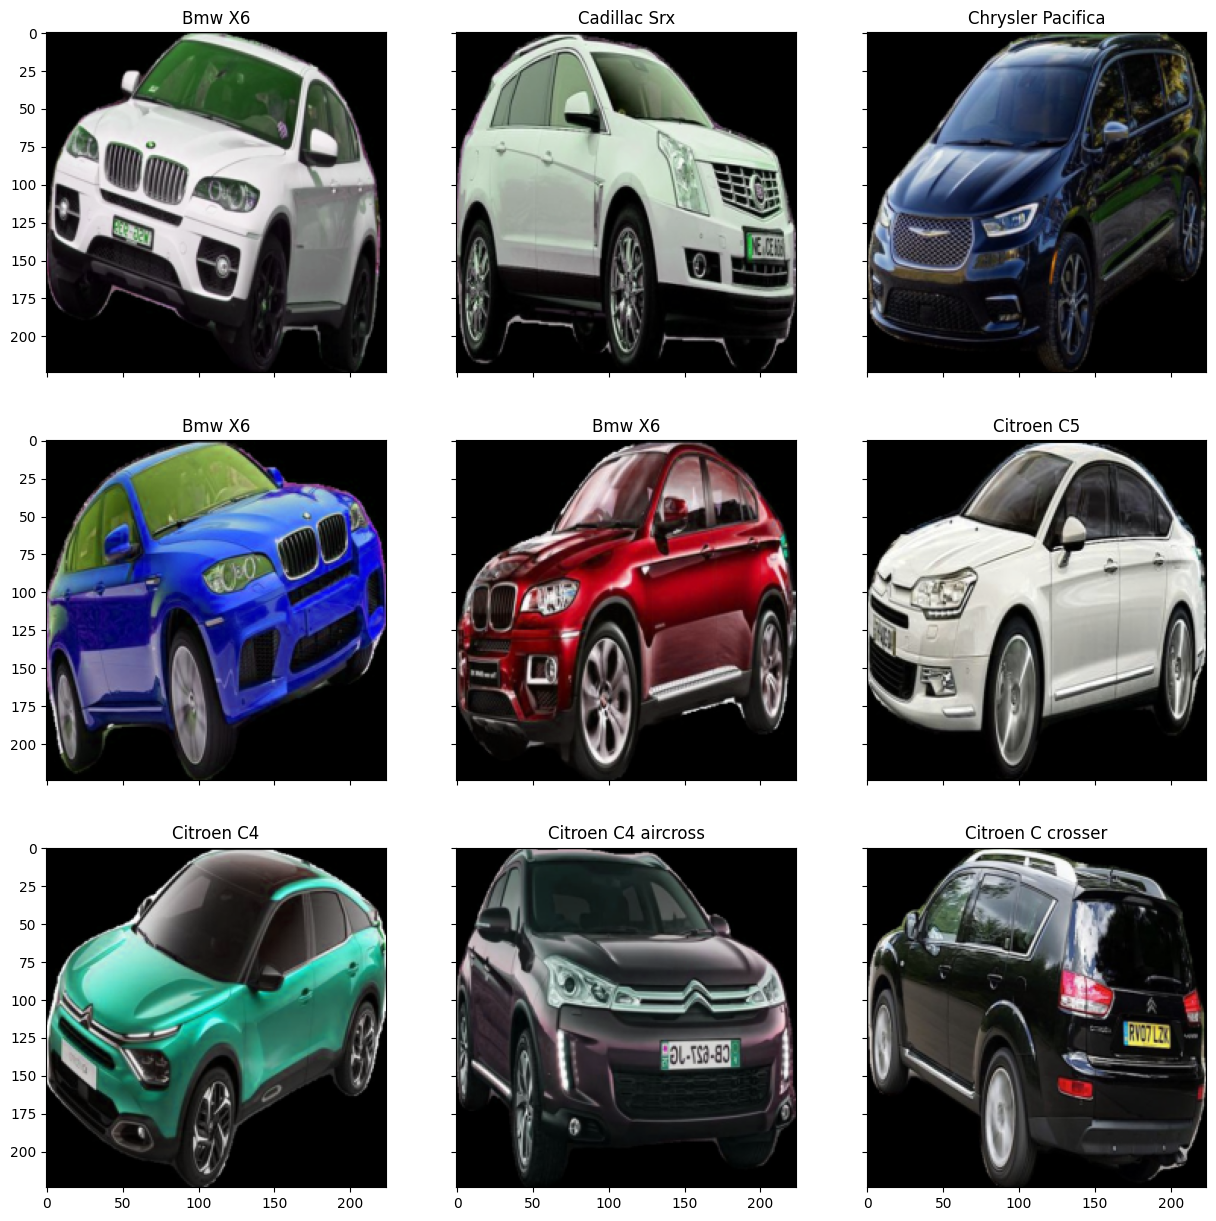

In [ ]:
# Run this cell and make sure there are images in correct transformations

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)

train_size = len(train_dataset)

label_encoder = LabelEncoder().fit(train_dataset.classes)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, train_size))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), str(label_encoder.inverse_transform([label])[0]).split('_')))
    plt.imshow(im_train.permute(1, 2, 0)  )
    imshow(im_train.data.cpu(), plt_ax=fig_x, title=img_label)

In [ ]:
def train(train_loader, val_loader, model, num_epochs, optimizer, criterion, scheduler=None):

    best_model_wts = model.state_dict()
    best_epoch = 0
    best_score = 0


    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    loaders = {"train": train_loader, "val": val_loader}

    for epoch in pbar:

        for k, dataloader in loaders.items():

            running_loss = 0.0
            epoch_preds, epoch_batches = [], []

            for batch in tqdm(dataloader, leave=False, desc=f"{k} iter:"):
                x_batch, y_batch = batch
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                        loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)

                epoch_preds += preds.cpu()
                epoch_batches += y_batch.cpu()
                running_loss += loss.item() * x_batch.size(0)

            epoch_score = accuracy_score(epoch_preds, epoch_batches)
            epoch_loss = running_loss / len(dataloader.dataset)
            losses[k].append(epoch_loss)



            if k == 'val':
              print(f'Epoch: {epoch + 1} of {num_epochs}  Score: {epoch_score}')
              if scheduler is not None:
                scheduler.step(epoch_loss)

            pbar.set_description('{} Loss: {:.4f} Score: {:.4f}'.format(k, epoch_loss, epoch_score))

            if k == 'val' and epoch_score > best_score:
               best_score = epoch_score
               best_epoch = epoch + 1
               best_model_wts = model.state_dict()



    print(f'Best score: {best_score}\nEpoch {best_epoch} of {num_epochs}')
    model.load_state_dict(best_model_wts)
    return model, losses, best_score

In [ ]:
torch.cuda.empty_cache()

In [ ]:
mob_netv3 = models.mobilenet_v3_large(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:02<00:00, 10.5MB/s]


In [ ]:
mob_netv3.classifier

Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
mob_netv3.classifier[3] = nn.Linear(in_features=mob_netv3.classifier[3].in_features, out_features=NCATS)

In [ ]:
mob_netv3 = mob_netv3.to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mob_netv3.parameters(), lr=1e-4, weight_decay = 1e-5)

mob_netv3, losses_mob_netv3, accuracy_mob_netv3 = train(trainloader, testloader, model=mob_netv3, num_epochs=25, optimizer=optimizer, criterion=criterion)

val Loss: 4.2123 Score: 0.0541:   4%|▍         | 1/25 [06:38<2:39:12, 398.04s/it]

Epoch: 1 of 25  Score: 0.05405405405405406



val Loss: 3.8600 Score: 0.1385:   8%|▊         | 2/25 [06:53<1:06:19, 173.02s/it]

Epoch: 2 of 25  Score: 0.13851351351351351



val Loss: 3.1576 Score: 0.2973:  12%|█▏        | 3/25 [07:09<37:06, 101.20s/it]  

Epoch: 3 of 25  Score: 0.2972972972972973



val Loss: 2.4443 Score: 0.4527:  16%|█▌        | 4/25 [07:25<23:37, 67.49s/it] 

Epoch: 4 of 25  Score: 0.4527027027027027



val Loss: 1.8353 Score: 0.5709:  20%|██        | 5/25 [07:40<16:15, 48.78s/it]

Epoch: 5 of 25  Score: 0.5709459459459459



val Loss: 1.4351 Score: 0.6689:  24%|██▍       | 6/25 [07:56<11:53, 37.57s/it]

Epoch: 6 of 25  Score: 0.668918918918919



val Loss: 1.2299 Score: 0.7230:  28%|██▊       | 7/25 [08:12<09:08, 30.48s/it]

Epoch: 7 of 25  Score: 0.722972972972973



val Loss: 1.1317 Score: 0.6858:  32%|███▏      | 8/25 [08:28<07:19, 25.82s/it]

Epoch: 8 of 25  Score: 0.6858108108108109



val Loss: 1.0053 Score: 0.7297:  36%|███▌      | 9/25 [08:45<06:09, 23.12s/it]

Epoch: 9 of 25  Score: 0.7297297297297297



val Loss: 0.9148 Score: 0.7568:  40%|████      | 10/25 [09:01<05:14, 20.99s/it]

Epoch: 10 of 25  Score: 0.7567567567567568



val Loss: 0.8649 Score: 0.7770:  44%|████▍     | 11/25 [09:17<04:32, 19.45s/it]

Epoch: 11 of 25  Score: 0.777027027027027



val Loss: 0.7912 Score: 0.7973:  48%|████▊     | 12/25 [09:33<03:58, 18.36s/it]

Epoch: 12 of 25  Score: 0.7972972972972973



val Loss: 0.7919 Score: 0.7939:  52%|█████▏    | 13/25 [09:49<03:31, 17.61s/it]

Epoch: 13 of 25  Score: 0.793918918918919



val Loss: 0.7719 Score: 0.7804:  56%|█████▌    | 14/25 [10:05<03:08, 17.15s/it]

Epoch: 14 of 25  Score: 0.7804054054054054



val Loss: 0.7675 Score: 0.7669:  60%|██████    | 15/25 [10:21<02:48, 16.84s/it]

Epoch: 15 of 25  Score: 0.7668918918918919



val Loss: 0.7400 Score: 0.7905:  64%|██████▍   | 16/25 [10:38<02:31, 16.82s/it]

Epoch: 16 of 25  Score: 0.7905405405405406



val Loss: 0.7291 Score: 0.7973:  68%|██████▊   | 17/25 [10:55<02:14, 16.79s/it]

Epoch: 17 of 25  Score: 0.7972972972972973



val Loss: 0.7133 Score: 0.7872:  72%|███████▏  | 18/25 [11:10<01:55, 16.49s/it]

Epoch: 18 of 25  Score: 0.7871621621621622



val Loss: 0.7040 Score: 0.7872:  76%|███████▌  | 19/25 [11:26<01:37, 16.28s/it]

Epoch: 19 of 25  Score: 0.7871621621621622



val Loss: 0.7068 Score: 0.7872:  80%|████████  | 20/25 [11:42<01:20, 16.18s/it]

Epoch: 20 of 25  Score: 0.7871621621621622



val Loss: 0.7166 Score: 0.7872:  84%|████████▍ | 21/25 [11:58<01:04, 16.07s/it]

Epoch: 21 of 25  Score: 0.7871621621621622



val Loss: 0.7223 Score: 0.7736:  88%|████████▊ | 22/25 [12:14<00:48, 16.04s/it]

Epoch: 22 of 25  Score: 0.7736486486486487



val Loss: 0.6941 Score: 0.7905:  92%|█████████▏| 23/25 [12:30<00:32, 16.01s/it]

Epoch: 23 of 25  Score: 0.7905405405405406



val Loss: 0.7040 Score: 0.7838:  96%|█████████▌| 24/25 [12:47<00:16, 16.35s/it]

Epoch: 24 of 25  Score: 0.7837837837837838



val Loss: 0.7174 Score: 0.7703: 100%|██████████| 25/25 [13:03<00:00, 31.35s/it]

Epoch: 25 of 25  Score: 0.7702702702702703
Best score: 0.7972972972972973
Epoch 12 of 25


In [ ]:
# torch.save(mob_netv3.state_dict(), '/content/drive/MyDrive/state_dict_mob_netv2_90_perc.pth')
torch.save(mob_netv3, '/content/drive/MyDrive/model_mob_netv3_79_perc.pth')

In [ ]:
from torchsummary import summary

model = mob_netv3
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

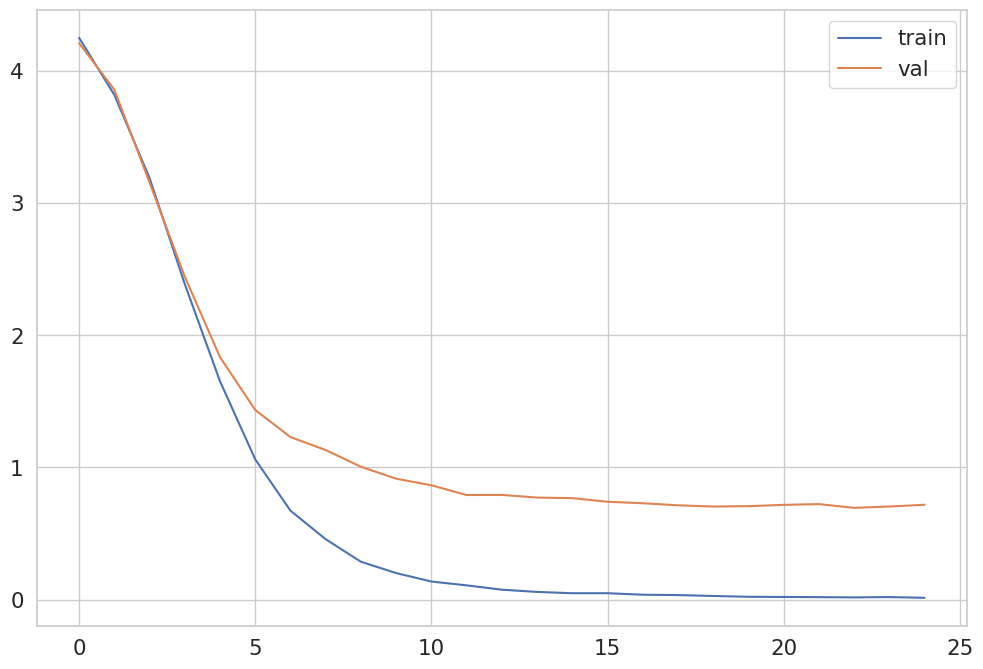

In [ ]:
plot_loss(losses_mob_netv3)